### Library install & import

In [144]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN
import warnings
warnings.filterwarnings(action='ignore') 
import random
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

### Load data

In [2]:
train_df = pd.read_csv('C:/Users/k_water/data_apo/data_tr_apo.csv')
train_df.columns = ['datetime', 'D'] 

test_df = pd.read_csv('C:/Users/k_water/data_apo/data_ts_apo.csv')
test_df.columns = ['datetime', 'D']

submission = pd.read_csv('C:/Users/k_water/data_apo/sample_apo.csv')

In [83]:
train_df

,datetime,D
0,2017-01-01 01:00:00,131.0
1,2017-01-01 02:00:00,64.0
2,2017-01-01 03:00:00,52.0
3,2017-01-01 04:00:00,50.0
4,2017-01-01 05:00:00,49.0
...,...,...
35058,2020-12-31 19:00:00,237.0
35059,2020-12-31 20:00:00,92.0
35060,2020-12-31 21:00:00,82.0
35061,2020-12-31 22:00:00,82.0


In [84]:
test_df

,datetime,D
0,2021-01-01 00:00:00,67.0
1,2021-01-01 01:00:00,70.0
2,2021-01-01 02:00:00,67.0
3,2021-01-01 03:00:00,59.0
4,2021-01-01 04:00:00,58.0
...,...,...
8419,2021-12-17 19:00:00,112.0
8420,2021-12-17 20:00:00,98.0
8421,2021-12-17 21:00:00,100.0
8422,2021-12-17 22:00:00,96.0


In [85]:
submission

,datetime,h0,h1,h2,h3,h4,h5,h6,h7,h8,...,h326,h327,h328,h329,h330,h331,h332,h333,h334,h335
0,2021-01-01 00:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-01-01 01:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-01-01 02:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-01-01 03:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-01-01 04:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8420,2021-12-17 20:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8421,2021-12-17 21:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8422,2021-12-17 22:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8423,2021-12-17 23:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Preprocessing

In [86]:
# datetime 열을 datetime 객체로 변환
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
test_df['datetime'] = pd.to_datetime(test_df['datetime'])
submission ['datetime'] = pd.to_datetime(submission ['datetime'])

# new features 생성 (년, 월, 일, 시간 분리)
train_df['year'] = train_df['datetime'].dt.year
train_df['month'] = train_df['datetime'].dt.month
train_df['day'] = train_df['datetime'].dt.day
train_df['hour'] = train_df['datetime'].dt.hour

test_df['year'] = test_df['datetime'].dt.year
test_df['month'] = test_df['datetime'].dt.month
test_df['day'] = test_df['datetime'].dt.day
test_df['hour'] = test_df['datetime'].dt.hour

train_df

,datetime,D,year,month,day,hour
0,2017-01-01 01:00:00,131.0,2017,1,1,1
1,2017-01-01 02:00:00,64.0,2017,1,1,2
2,2017-01-01 03:00:00,52.0,2017,1,1,3
3,2017-01-01 04:00:00,50.0,2017,1,1,4
4,2017-01-01 05:00:00,49.0,2017,1,1,5
...,...,...,...,...,...,...
35058,2020-12-31 19:00:00,237.0,2020,12,31,19
35059,2020-12-31 20:00:00,92.0,2020,12,31,20
35060,2020-12-31 21:00:00,82.0,2020,12,31,21
35061,2020-12-31 22:00:00,82.0,2020,12,31,22


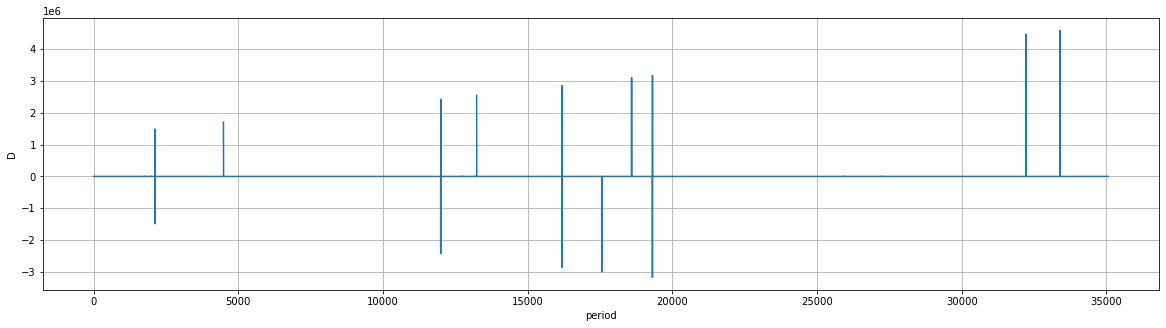

In [87]:
# 그래프 확인
plt.figure(figsize=(20, 5))
plt.ylabel('D')
plt.xlabel('period')
plt.grid()
plt.plot(train_df.D, label='D')

plt.show()

In [89]:
# 통계 정보 확인
print('max:', max(train_df.D))
print('min:', min(train_df.D))
print('mean:', train_df.D.mean())
print('median:', train_df.D.median())
print('std:', train_df.D.std())

max: 4584869.0
min: -3170191.0
mean: 481.7961029327856
median: 92.0
std: 58871.68285287981


### # 이상치 처리

In [90]:
# 평균보다 높은 값 확인
train_df[train_df.D >= train_df.D.mean()]

,datetime,D,year,month,day,hour
2128,2017-03-30 17:00:00,1486478.0,2017,3,30,17
4485,2017-07-06 22:00:00,1702320.0,2017,7,6,22
4526,2017-07-08 15:00:00,492.0,2017,7,8,15
9544,2018-02-02 17:00:00,1671.0,2018,2,2,17
10208,2018-03-02 09:00:00,591.0,2018,3,2,9
11995,2018-05-15 20:00:00,2422577.0,2018,5,15,20
13235,2018-07-06 12:00:00,2545779.0,2018,7,6,12
16194,2018-11-06 19:00:00,2855497.0,2018,11,6,19
18590,2019-02-14 15:00:00,3102464.0,2019,2,14,15
19312,2019-03-16 17:00:00,3170612.0,2019,3,16,17


In [91]:
# 첫번째행 2128의 'D'값 처리를 위해 앞 뒤 5개씩 값 확인
train_df[(train_df.index >= 2123) & (train_df.index <= 2132)]

,datetime,D,year,month,day,hour
2123,2017-03-30 12:00:00,134.0,2017,3,30,12
2124,2017-03-30 13:00:00,97.0,2017,3,30,13
2125,2017-03-30 14:00:00,97.0,2017,3,30,14
2126,2017-03-30 15:00:00,87.0,2017,3,30,15
2127,2017-03-30 16:00:00,-1486262.0,2017,3,30,16
2128,2017-03-30 17:00:00,1486478.0,2017,3,30,17
2129,2017-03-30 18:00:00,115.0,2017,3,30,18
2130,2017-03-30 19:00:00,97.0,2017,3,30,19
2131,2017-03-30 20:00:00,102.0,2017,3,30,20
2132,2017-03-30 21:00:00,158.0,2017,3,30,21


In [92]:
# 발견된 이상치(2127, 2128) 처리 - 전후 값을 이용하여 선형 보간
train_df.loc[train_df.index == 2127 ,'D'] = int(87 + (115-87)/3*1)
train_df.loc[train_df.index == 2128 ,'D'] = int(87 + (115-87)/3*2)

In [93]:
# 동일한 방법으로 다른 값들 보간
train_df.loc[train_df.index == 4484 ,'D'] = int(85 + (129 - 85)/3*1)
train_df.loc[train_df.index == 4485 ,'D'] = int(85 + (129 - 85)/3*2)

train_df.loc[train_df.index == 11993 ,'D'] = 82 + (118-82)/4*1
train_df.loc[train_df.index == 11994 ,'D'] = 82 + (118-82)/4*2
train_df.loc[train_df.index == 11995 ,'D'] = 82 + (118-82)/4*3

In [94]:
# 전후 값이 거의 유사한 경우에는 하나의 값으로 채우기
train_df.loc[train_df.index == 13234 ,'D'] = 94 
train_df.loc[train_df.index == 13235 ,'D'] = 94

train_df.loc[train_df.index == 19310 ,'D'] = 93 
train_df.loc[train_df.index == 19311 ,'D'] = 93
train_df.loc[train_df.index == 19312 ,'D'] = 93

train_df.loc[train_df.index == 16193 ,'D'] = 88
train_df.loc[train_df.index == 16194 ,'D'] = 88
train_df.loc[train_df.index == 16195 ,'D'] = 88 #급격한 기울기 변화에 따라 이상치로 판단

train_df.loc[train_df.index == 17558 ,'D'] = (110 + 88) /2

train_df.loc[train_df.index == 18590 ,'D'] = (108 + 92) /2

train_df.loc[train_df.index == 32226 ,'D'] = (245 + 99) /2
train_df.loc[train_df.index == 33396 ,'D'] = (104 + 99) /2

train_df.loc[train_df.index == 9544 ,'D'] = (142 + 93) /2

train_df.loc[train_df.index == 26463 ,'D'] = (104 + 89) /2
train_df.loc[train_df.index == 29097 ,'D'] = (148 + 117) /2

train_df.loc[train_df.index == 10205 ,'D'] = int(35 + (106 - 35)/5*1)
train_df.loc[train_df.index == 10206 ,'D'] = int(35 + (106 - 35)/5*2)
train_df.loc[train_df.index == 10207 ,'D'] = int(35 + (106 - 35)/5*3)
train_df.loc[train_df.index == 10208 ,'D'] = int(35 + (106 - 35)/5*4)

train_df.loc[train_df.index == 4523 ,'D'] = int(80 + (148 - 80)/5*1)
train_df.loc[train_df.index == 4524 ,'D'] = int(80 + (148 - 80)/5*2)
train_df.loc[train_df.index == 4525 ,'D'] = int(80 + (148 - 80)/5*3)
train_df.loc[train_df.index == 4526 ,'D'] = int(80 + (148 - 80)/5*4)

In [95]:
# 통계 정보 확인
print('max:', max(train_df.D))
print('min:', min(train_df.D))
print('mean:', train_df.D.mean())
print('median:', train_df.D.median())
print('std:', train_df.D.std())

max: 370.0
min: 0.0
mean: 99.28133736520796
median: 92.0
std: 46.91774896165821


In [96]:
# 결측치 확인
train_df[train_df.D.isna()]

,datetime,D,year,month,day,hour
1748,2017-03-14 21:00:00,NaN,2017,3,14,21
1982,2017-03-24 15:00:00,NaN,2017,3,24,15
12716,2018-06-14 21:00:00,NaN,2018,6,14,21
12717,2018-06-14 22:00:00,NaN,2018,6,14,22
13187,2018-07-04 12:00:00,NaN,2018,7,4,12
25934,2019-12-17 15:00:00,NaN,2019,12,17,15
25935,2019-12-17 16:00:00,NaN,2019,12,17,16
27253,2020-02-10 14:00:00,NaN,2020,2,10,14
27254,2020-02-10 15:00:00,NaN,2020,2,10,15


In [97]:
train_df.loc[train_df.index == 1748,'D'] = (91+145)/2
train_df.loc[train_df.index == 1982,'D'] = (85+174)/2

train_df.loc[train_df.index == 12716,'D'] = int(71 + (103-71)/3*1)
train_df.loc[train_df.index == 12717,'D'] = int(71 + (103-71)/3*2)

train_df.loc[train_df.index == 25934,'D'] = int(90 + (98-90)/3*1)
train_df.loc[train_df.index == 25935,'D'] = int(90 + (98-90)/3*2)

train_df.loc[train_df.index == 27253,'D'] = int(83 + (97-83)/3*1)
train_df.loc[train_df.index == 27254,'D'] = int(83 + (97-83)/3*2)

train_df.loc[train_df.index == 13187,'D'] = (105+110)/2

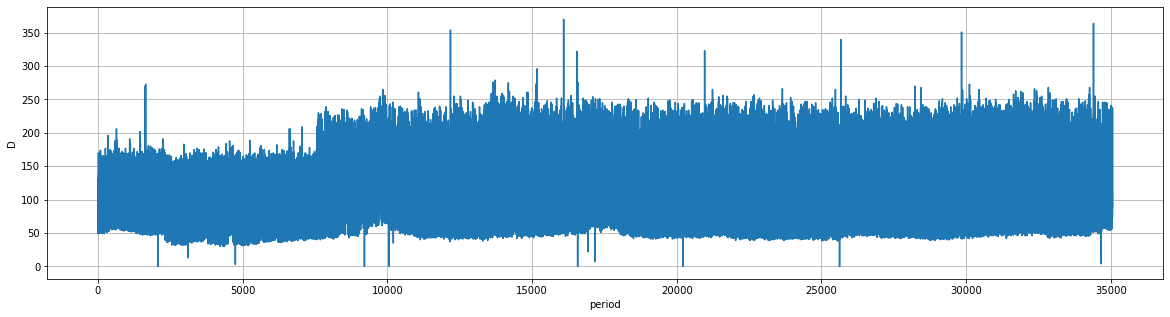

In [98]:
# 그래프 확인
plt.figure(figsize=(20, 5))
plt.ylabel('D')
plt.xlabel('period')
plt.grid()
plt.plot(train_df.D, label='D')

plt.show()

In [102]:
# 그래프로 확인한 데이터의 피크값의 상·하안을 250과 45로 설정함. 
# 그 외의 보간법은 이전과 같음.

train_df.loc[train_df.index == 16554 ,'D'] = (95 + 61)/2
train_df.loc[train_df.index == 34402 ,'D'] = 250
train_df.loc[train_df.index == 29842 ,'D'] = 250

train_df.loc[train_df.index == 25666 ,'D'] = 240
train_df.loc[train_df.index == 25667 ,'D'] = 250

train_df.loc[train_df.index == 12179 ,'D'] = 250

train_df.loc[train_df.index == 16091 ,'D'] = 250
train_df.loc[train_df.index == 16091 ,'D'] = 240

train_df.loc[train_df.index == 20962 ,'D'] = 240
train_df.loc[train_df.index == 20963 ,'D'] = 250
train_df.loc[train_df.index == 20964 ,'D'] = 240

train_df.loc[train_df.index == 15178 ,'D'] = 250
train_df.loc[train_df.index == 16092 ,'D'] = 250
train_df.loc[train_df.index == 20963 ,'D'] = 240
train_df.loc[train_df.index == 25667,'D'] = 250

train_df.loc[train_df.D >= 250, 'D'] = 250
train_df.loc[train_df.D <= 40, 'D'] = 45

train_df.loc[train_df.index == 1619,'D'] = 200
train_df.loc[train_df.index == 1620,'D'] = 200
train_df.loc[train_df.index == 1621,'D'] = 200

train_df.loc[train_df.index == 1640,'D'] = 190
train_df.loc[train_df.index == 1641,'D'] = 190
train_df.loc[train_df.index == 1642,'D'] = 190
train_df.loc[train_df.index == 1643,'D'] = 200
train_df.loc[train_df.index == 1644,'D'] = 200
train_df.loc[train_df.index == 1645,'D'] = 200

train_df.loc[(train_df.year == 2017) & (train_df.D > 230), 'D'] = 200

In [103]:
# 데이터의 stationary 확인
from statsmodels.tsa.stattools import adfuller
def print_adfuller(inputSeries):
    result = adfuller(inputSeries, autolag=None, maxlag=336)
    dfoutput = pd.Series(result[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key, value in result[4].items():
        dfoutput['Critical Value ({})'.format(key)] = value
    print(dfoutput)
print_adfuller(train_df['D'])
print("--------")
print_adfuller(test_df['D'])
print("--------")

# 데이터가 어느 정도 stationary하다고 볼 수 있음

test statistic             -4.780179
p-value                     0.000059
# of lags                 336.000000
# of observations       34726.000000
Critical Value (1%)        -3.430538
Critical Value (5%)        -2.861623
Critical Value (10%)       -2.566814
dtype: float64
--------
test statistic            -3.316289
p-value                    0.014166
# of lags                336.000000
# of observations       8087.000000
Critical Value (1%)       -3.431159
Critical Value (5%)       -2.861897
Critical Value (10%)      -2.566960
dtype: float64
--------


### # Train, Test 데이터 생성

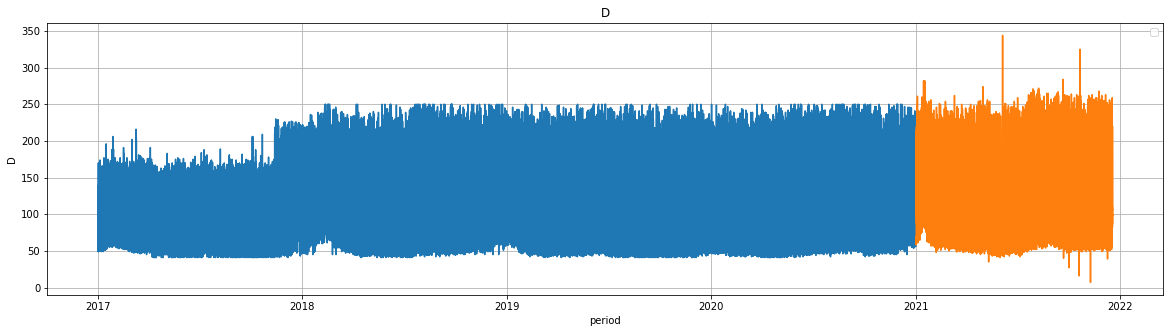

In [104]:
# datetime을 index로 지정
train_df = train_df.set_index('datetime')
test_df = test_df.set_index('datetime')

# 그래프 그려서 범위 보기
plt.figure(figsize=(20, 5))
plt.title('D')
plt.ylabel('D')
plt.xlabel('period')
plt.grid()
plt.legend(['train', 'test'])
plt.plot(train_df['D'], label='D')
plt.plot(test_df['D'], label='D')

plt.show()

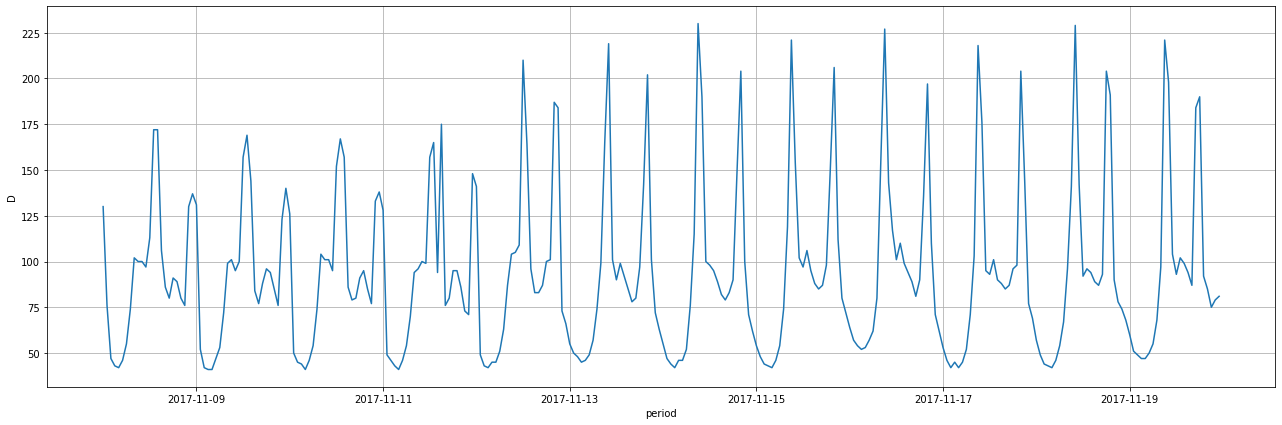

In [107]:
# 데이터 분포가 눈에 띄게 변하는 구간 확인

plt.figure(figsize=(22, 7))
plt.ylabel('D')
plt.xlabel('period')
plt.grid()
plt.plot(train_df.loc['2017-11-8':'2017-11-19','D'], label='D')

plt.show()

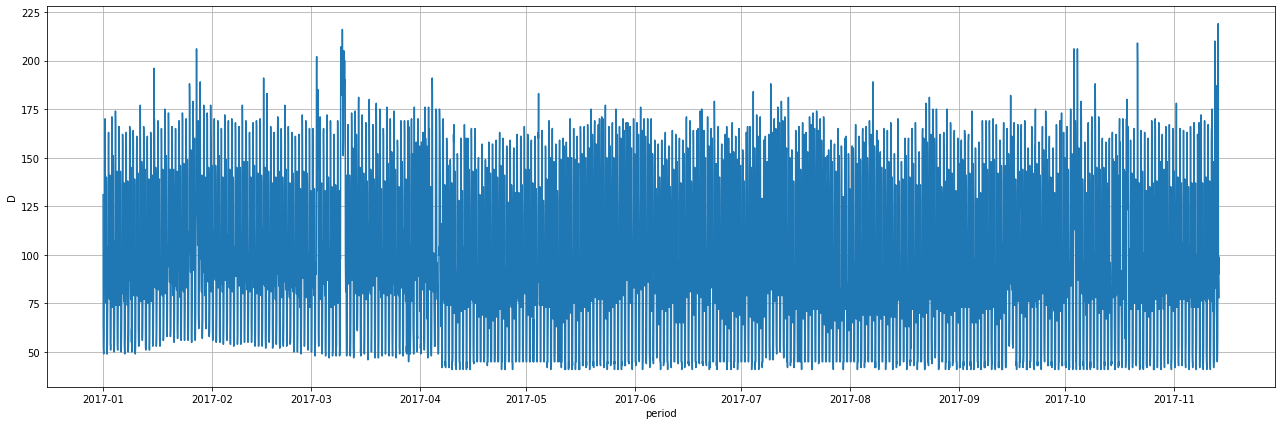

In [126]:
# 2017년 11월 13일에 포함된 7600번째 행 기준으로 분리 후 전후 비교
plt.figure(figsize=(22, 7))
plt.ylabel('D')
plt.xlabel('period')
plt.grid()
plt.plot(train_df.iloc[:7600].D, label='D')

plt.show()

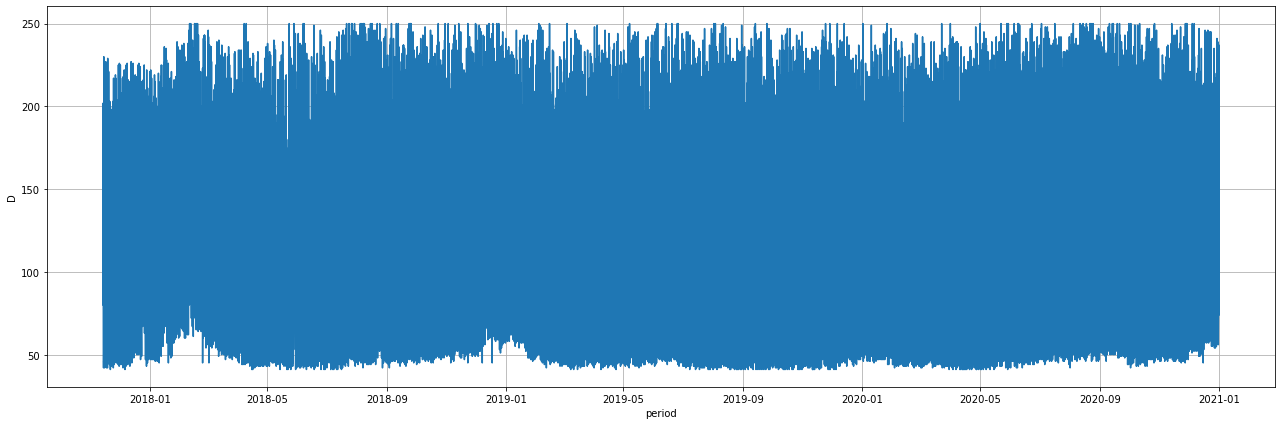

In [125]:
plt.figure(figsize=(22, 7))
plt.ylabel('D')
plt.xlabel('period')
plt.grid()
plt.plot(train_df.iloc[7600:].D, label='D')

plt.show()

In [127]:
# train, test 병합
X = pd.concat([train_df, test_df])

In [128]:
# 제출 형식에 맞게 데이터 프레임 생성
for i in range(0,336):
    X[f'h{i}'] = 0
    
X['h0'] = X['D']

for i in range(1, 336):
    X[f'h{i}'] = X['D'].shift(-i)

In [129]:
# 누락돼 있는 '2021-12-18 00:00:00' 행 생성
X.loc['2021-12-18 00:00:00'] = np.nan
X.loc['2021-12-18 00:00:00'].year = 2021
X.loc['2021-12-18 00:00:00'].month = 12
X.loc['2021-12-18 00:00:00'].day = 18
X.loc['2021-12-18 00:00:00'].hour = 0

In [130]:
# '2021-12-04 00:00:00' 행까지 데이터가 완전히 채워진 것을 확인
X[(X.year==2021) & (X.month==12) & (X.day >= 4 )]

,D,year,month,day,hour,h0,h1,h2,h3,h4,...,h326,h327,h328,h329,h330,h331,h332,h333,h334,h335
datetime,,,,,,,,,,,,,,,,,,,,,
2021-12-04 00:00:00,68.0,2021.0,12.0,4.0,0.0,68.0,65.0,58.0,57.0,55.0,...,107.0,101.0,87.0,152.0,220.0,112.0,98.0,100.0,96.0,83.0
2021-12-04 01:00:00,65.0,2021.0,12.0,4.0,1.0,65.0,58.0,57.0,55.0,58.0,...,101.0,87.0,152.0,220.0,112.0,98.0,100.0,96.0,83.0,NaN
2021-12-04 02:00:00,58.0,2021.0,12.0,4.0,2.0,58.0,57.0,55.0,58.0,64.0,...,87.0,152.0,220.0,112.0,98.0,100.0,96.0,83.0,NaN,NaN
2021-12-04 03:00:00,57.0,2021.0,12.0,4.0,3.0,57.0,55.0,58.0,64.0,80.0,...,152.0,220.0,112.0,98.0,100.0,96.0,83.0,NaN,NaN,NaN
2021-12-04 04:00:00,55.0,2021.0,12.0,4.0,4.0,55.0,58.0,64.0,80.0,106.0,...,220.0,112.0,98.0,100.0,96.0,83.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-17 20:00:00,98.0,2021.0,12.0,17.0,20.0,98.0,100.0,96.0,83.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-17 21:00:00,100.0,2021.0,12.0,17.0,21.0,100.0,96.0,83.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-17 22:00:00,96.0,2021.0,12.0,17.0,22.0,96.0,83.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
# 완전하게 채워지지 않은 부분 삭제 후 train 데이터 생성
temp = X[(X.year==2021) & (X.month==12) & (X.day >= 4 )]
TRAIN = X.drop(temp.index)

# test 데이터 생성 (train 데이터에서 2021 데이터 추출)
TEST = TRAIN[TRAIN.year == 2021]

# train 데이터에서 test 데이터 삭제
TRAIN = TRAIN.drop(TEST.index)
TRAIN

,D,year,month,day,hour,h0,h1,h2,h3,h4,...,h326,h327,h328,h329,h330,h331,h332,h333,h334,h335
datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-01 01:00:00,131.0,2017.0,1.0,1.0,1.0,131.0,64.0,52.0,50.0,49.0,...,140.0,76.0,82.0,87.0,92.0,83.0,82.0,77.0,90.0,141.0
2017-01-01 02:00:00,64.0,2017.0,1.0,1.0,2.0,64.0,52.0,50.0,49.0,53.0,...,76.0,82.0,87.0,92.0,83.0,82.0,77.0,90.0,141.0,137.0
2017-01-01 03:00:00,52.0,2017.0,1.0,1.0,3.0,52.0,50.0,49.0,53.0,59.0,...,82.0,87.0,92.0,83.0,82.0,77.0,90.0,141.0,137.0,72.0
2017-01-01 04:00:00,50.0,2017.0,1.0,1.0,4.0,50.0,49.0,53.0,59.0,73.0,...,87.0,92.0,83.0,82.0,77.0,90.0,141.0,137.0,72.0,53.0
2017-01-01 05:00:00,49.0,2017.0,1.0,1.0,5.0,49.0,53.0,59.0,73.0,89.0,...,92.0,83.0,82.0,77.0,90.0,141.0,137.0,72.0,53.0,53.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,237.0,2020.0,12.0,31.0,19.0,237.0,92.0,82.0,82.0,74.0,...,282.0,179.0,145.0,145.0,151.0,142.0,133.0,126.0,252.0,200.0
2020-12-31 20:00:00,92.0,2020.0,12.0,31.0,20.0,92.0,82.0,82.0,74.0,67.0,...,179.0,145.0,145.0,151.0,142.0,133.0,126.0,252.0,200.0,141.0
2020-12-31 21:00:00,82.0,2020.0,12.0,31.0,21.0,82.0,82.0,74.0,67.0,70.0,...,145.0,145.0,151.0,142.0,133.0,126.0,252.0,200.0,141.0,130.0


In [133]:
# 예측에 사용할 데이터 범위 선택 (window-size)
temp1 = X[(X.year >= 2020) & (X.month == 12) & (X.day >= 28)] 
temp1

,D,year,month,day,hour,h0,h1,h2,h3,h4,...,h326,h327,h328,h329,h330,h331,h332,h333,h334,h335
datetime,,,,,,,,,,,,,,,,,,,,,
2020-12-28 00:00:00,64.0,2020.0,12.0,28.0,0.0,64.0,57.0,55.0,55.0,54.0,...,116.0,111.0,128.0,246.0,149.0,118.0,106.0,106.0,94.0,93.0
2020-12-28 01:00:00,57.0,2020.0,12.0,28.0,1.0,57.0,55.0,55.0,54.0,56.0,...,111.0,128.0,246.0,149.0,118.0,106.0,106.0,94.0,93.0,81.0
2020-12-28 02:00:00,55.0,2020.0,12.0,28.0,2.0,55.0,55.0,54.0,56.0,61.0,...,128.0,246.0,149.0,118.0,106.0,106.0,94.0,93.0,81.0,146.0
2020-12-28 03:00:00,55.0,2020.0,12.0,28.0,3.0,55.0,54.0,56.0,61.0,74.0,...,246.0,149.0,118.0,106.0,106.0,94.0,93.0,81.0,146.0,154.0
2020-12-28 04:00:00,54.0,2020.0,12.0,28.0,4.0,54.0,56.0,61.0,74.0,96.0,...,149.0,118.0,106.0,106.0,94.0,93.0,81.0,146.0,154.0,79.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,237.0,2020.0,12.0,31.0,19.0,237.0,92.0,82.0,82.0,74.0,...,282.0,179.0,145.0,145.0,151.0,142.0,133.0,126.0,252.0,200.0
2020-12-31 20:00:00,92.0,2020.0,12.0,31.0,20.0,92.0,82.0,82.0,74.0,67.0,...,179.0,145.0,145.0,151.0,142.0,133.0,126.0,252.0,200.0,141.0
2020-12-31 21:00:00,82.0,2020.0,12.0,31.0,21.0,82.0,82.0,74.0,67.0,70.0,...,145.0,145.0,151.0,142.0,133.0,126.0,252.0,200.0,141.0,130.0


In [136]:
# submission form 만들기
temp2 = X[(X.year == 2021) & (X.month >= 1)] # 2021년 데이터 추출
submission_form = pd.concat([temp1, temp2]) # 예측에 사용할 데이터와 병합
submission_form

,D,year,month,day,hour,h0,h1,h2,h3,h4,...,h326,h327,h328,h329,h330,h331,h332,h333,h334,h335
datetime,,,,,,,,,,,,,,,,,,,,,
2020-12-28 00:00:00,64.0,2020.0,12.0,28.0,0.0,64.0,57.0,55.0,55.0,54.0,...,116.0,111.0,128.0,246.0,149.0,118.0,106.0,106.0,94.0,93.0
2020-12-28 01:00:00,57.0,2020.0,12.0,28.0,1.0,57.0,55.0,55.0,54.0,56.0,...,111.0,128.0,246.0,149.0,118.0,106.0,106.0,94.0,93.0,81.0
2020-12-28 02:00:00,55.0,2020.0,12.0,28.0,2.0,55.0,55.0,54.0,56.0,61.0,...,128.0,246.0,149.0,118.0,106.0,106.0,94.0,93.0,81.0,146.0
2020-12-28 03:00:00,55.0,2020.0,12.0,28.0,3.0,55.0,54.0,56.0,61.0,74.0,...,246.0,149.0,118.0,106.0,106.0,94.0,93.0,81.0,146.0,154.0
2020-12-28 04:00:00,54.0,2020.0,12.0,28.0,4.0,54.0,56.0,61.0,74.0,96.0,...,149.0,118.0,106.0,106.0,94.0,93.0,81.0,146.0,154.0,79.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-17 20:00:00,98.0,2021.0,12.0,17.0,20.0,98.0,100.0,96.0,83.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-17 21:00:00,100.0,2021.0,12.0,17.0,21.0,100.0,96.0,83.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-17 22:00:00,96.0,2021.0,12.0,17.0,22.0,96.0,83.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
# 최종 window-size 설정 (모델마다 window-size 다르게 설정함)
window_size = submission_form.shape[0]-8425  
window_size

96

In [139]:
# 학습에 사용될 feature 선택
# 여러가지 feature들을 생성하고 테스트 해본 결과 유량적산차를 단독으로 사용한 모델의 성능이 가장 좋았음.
feature_cols = ['D']
label_cols = [f'h{i}' for i in range(336)]

train_feature_df = pd.DataFrame(TRAIN, columns=feature_cols)
train_label_df = pd.DataFrame(TRAIN, columns=label_cols)
test_feature_df = pd.DataFrame(TEST, columns=feature_cols)
test_label_df = pd.DataFrame(TEST, columns=label_cols)
submission_feature_df = pd.DataFrame(submission_form, columns=feature_cols)
submission_label_df = pd.DataFrame(submission_form, columns=label_cols)

In [140]:
# 데이터 분포가 눈에 띄게 변하는 2017년 앞부분 데이터 빼기
train_feature_df = train_feature_df[7600:]
train_label_df = train_label_df[7600:]

In [141]:
# 데이터 프레임 numpy로 변경
train_feature_np = train_feature_df.to_numpy()
train_label_np = train_label_df.to_numpy()
test_feature_np = test_feature_df.to_numpy()
test_label_np = test_label_df.to_numpy()
submission_feature_np = submission_feature_df.to_numpy()
submission_label_np = submission_label_df.to_numpy()

print(train_feature_np.shape, train_label_np.shape)
print(test_feature_np.shape, test_label_np.shape)
print(submission_feature_np.shape, submission_label_np.shape)

(27463, 1) (27463, 336)
(8088, 1) (8088, 336)
(8521, 1) (8521, 336)


In [142]:
# 시계열 데이터 생성 함수
def make_sequene_dataset(feature, label, window_size):
    feature_list = []     
    label_list = [] 
    for i in range(len(feature)-window_size):
        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])
    return np.array(feature_list), np.array(label_list)

In [143]:
# 설정한 window_size에 맞게 시계열 데이터 생성
window_size = window_size
x_train, y_train = make_sequene_dataset(train_feature_np, train_label_np, window_size)
x_test, y_test = make_sequene_dataset(test_feature_np, test_label_np, window_size)
submission_x, submission_y = make_sequene_dataset(submission_feature_np, submission_label_np, window_size)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(submission_x.shape)

(27367, 96, 1) (27367, 336)
(7992, 96, 1) (7992, 336)
(8425, 96, 1)
